# TSAI Forecasting Implementation
Based on:
- https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/15_PatchTST_a_new_transformer_for_LTSF.ipynb (Notebook Base)
- https://wandb.ai/timeseriesbois/PhysioNet_Challenge/reports/Time-Series-Classification-on-Weights-Biases-with-TSAI--VmlldzoxODM4ODU4?galleryTag=intermediate

Todo:
- Get last part working
- Add WandB

In [1]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('cex4WindDataInterpolated.csv')

# convert time to datetime
df['t'] = pd.to_datetime(df['t'])

# time collumns: t, toy

# target must be float
# df['p'] = df['p'].astype(float)

# variables to use for predictions: Ws, Wd, T

# drop NA
# df.dropna(inplace=True)

# add forward fill
# df.ffill(inplace=True)

df.head()

,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,0.125,1.267,4.9,135.0,275.8,4.9,135.0,275.8,4.9,135.0,275.8
1,1999-01-01 04:00:00,0.167,1.515,5.0,126.9,275.8,5.0,126.9,275.8,5.0,126.9,275.8
2,1999-01-01 05:00:00,0.208,1.915,5.9,135.7,275.5,5.9,135.7,275.5,5.9,135.7,275.5
3,1999-01-01 06:00:00,0.250,1.613,5.3,146.6,275.0,5.3,146.6,275.0,5.3,146.6,275.0
4,1999-01-01 07:00:00,0.292,1.776,6.1,117.4,274.5,5.9,130.2,274.8,5.9,130.2,274.8


In [4]:
import sklearn
from tsai.basics import *
my_setup(sklearn)

os              : Linux-6.1.58+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
sklearn         : 1.2.2
torch           : 2.1.0+cu121
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : N/A


In [5]:
datetime_col = "t"
freq = '24h'
columns = df.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ],
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df)
df

data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 3.47 MB   
Final memory usage  : 1.88 MB    (-45.8%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.1s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,0.125,1.267,4.900000,135.000000,275.799988,4.900000,135.000000,275.799988,4.900000,135.000000,275.799988
1,1999-01-02 03:00:00,1.125,8.152,9.000000,154.300003,273.500000,9.000000,154.300003,273.500000,9.000000,154.300003,273.500000
2,1999-01-03 03:00:00,2.125,9.368,8.100000,183.500000,277.200012,8.100000,183.500000,277.200012,8.100000,183.500000,277.200012
3,1999-01-04 03:00:00,3.125,4.794,8.200000,199.300003,275.399994,8.200000,199.300003,275.399994,8.200000,199.300003,275.399994
4,1999-01-05 03:00:00,4.125,20.201,19.299999,252.500000,278.000000,19.299999,252.500000,278.000000,19.299999,252.500000,278.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2003-04-26 03:00:00,115.125,14.810,13.400000,111.400002,278.100006,13.400000,111.400002,278.100006,13.400000,111.400002,278.100006
1577,2003-04-27 03:00:00,116.125,0.008,2.600000,65.400002,279.799988,2.600000,65.400002,279.799988,2.600000,65.400002,279.799988
1578,2003-04-28 03:00:00,117.125,2.063,6.100000,253.899994,279.799988,6.100000,253.899994,279.799988,6.100000,253.899994,279.799988
1579,2003-04-29 03:00:00,118.125,3.952,8.100000,185.600006,282.799988,8.100000,185.600006,282.799988,8.100000,185.600006,282.799988


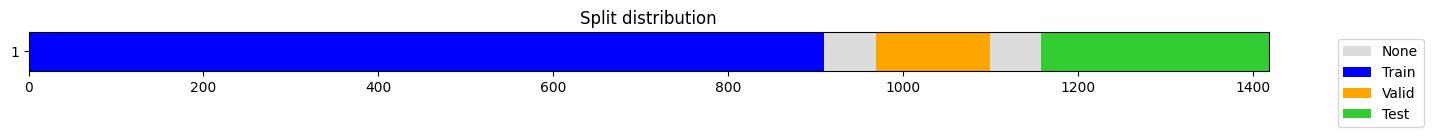

((#910) [0,1,2,3,4,5,6,7,8,9...],
 (#130) [969,970,971,972,973,974,975,976,977,978...],
 (#260) [1158,1159,1160,1161,1162,1163,1164,1165,1166,1167...])

In [6]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

In [7]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ],
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,-1.573283,-0.591372,-0.754664,-0.694234,-0.858250,-0.754735,-0.694316,-0.857825,-0.754509,-0.689355,-0.857882
1,1999-01-02 03:00:00,-1.563684,0.680770,0.256933,-0.478781,-1.293281,0.256976,-0.478891,-1.292751,0.257288,-0.474142,-1.292796
2,1999-01-03 03:00:00,-1.554086,0.905451,0.034875,-0.152811,-0.593443,0.034893,-0.152963,-0.593082,0.035186,-0.148535,-0.593146
3,1999-01-04 03:00:00,-1.544487,0.060312,0.059548,0.023569,-0.933907,0.059569,0.023395,-0.933463,0.059864,0.027649,-0.933519
4,1999-01-05 03:00:00,-1.534888,2.907066,2.798260,0.617460,-0.442130,2.798591,0.617208,-0.441805,2.799119,0.620879,-0.441873
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2003-04-26 03:00:00,-0.469445,1.910970,1.342548,-0.957689,-0.423214,1.342715,-0.957737,-0.422893,1.343119,-0.952517,-0.422963
1577,2003-04-27 03:00:00,-0.459846,-0.823998,-1.322145,-1.471203,-0.101672,-1.322280,-1.471184,-0.101428,-1.322102,-1.465459,-0.101506
1578,2003-04-28 03:00:00,-0.450248,-0.444295,-0.458587,0.633088,-0.101672,-0.458624,0.632835,-0.101428,-0.458373,0.636490,-0.101506
1579,2003-04-29 03:00:00,-0.440649,-0.095265,0.034875,-0.129368,0.465762,0.034893,-0.129523,0.465869,0.035186,-0.125118,0.465775


In [8]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [9]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((1418, 11, 104), (1418, 11, 60))

In [10]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [11]:
learn = TSForecaster(X, y, splits=splits, batch_size=8, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())


In [12]:
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 8 x 11 x 104)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 11 x 60         
RevIN                                     22         True      
____________________________________________________________________________
                     8 x 11 x 106        
ReplicationPad1d                                               
____________________________________________________________________________
                     8 x 24 x 42         
Unfold                                                         
____________________________________________________________________________
                     8 x 11 x 42 x 16    
Linear                                    400        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272       

epoch,train_loss,valid_loss,mse,mae,time
0,1.109929,1.440087,1.440087,0.936754,00:14
1,0.988876,1.134652,1.134652,0.824028,00:11
2,0.928884,1.117561,1.117561,0.815489,00:11


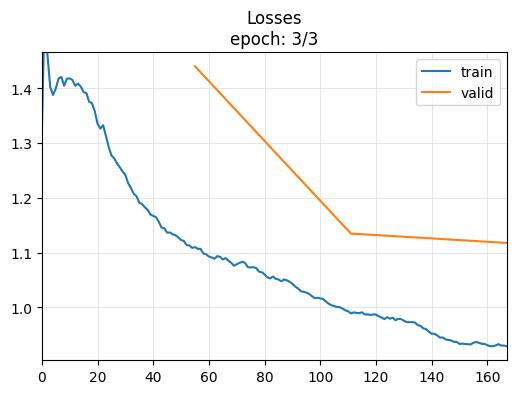

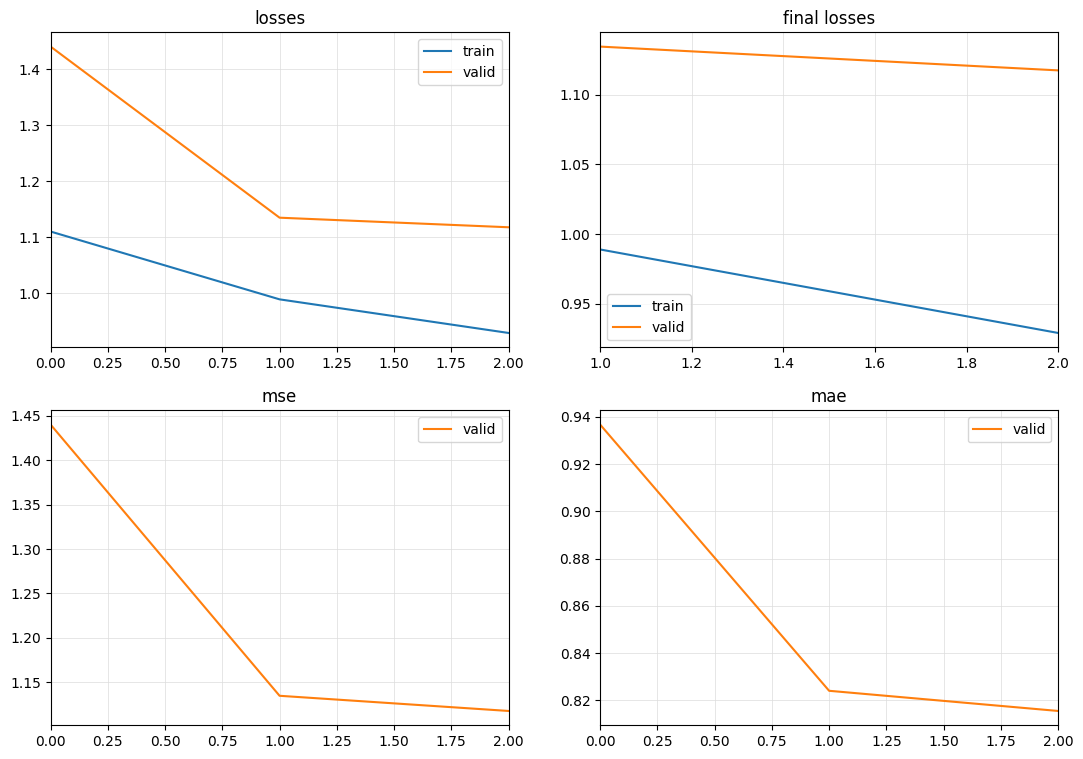

In [13]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 3
lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

# Evaluate Model

In [14]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

scaled_preds.shape: (130, 11, 60)


,mse,mae
valid,1.117561,0.815489


# Test split

In [15]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (260, 11, 60)


,mse,mae
test,1.03861,0.795611


## Visualize Predictions

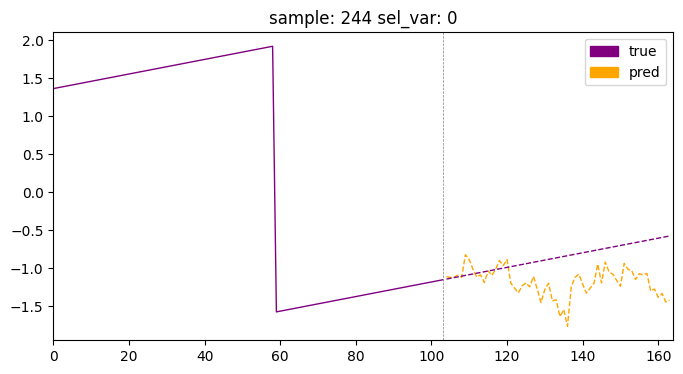

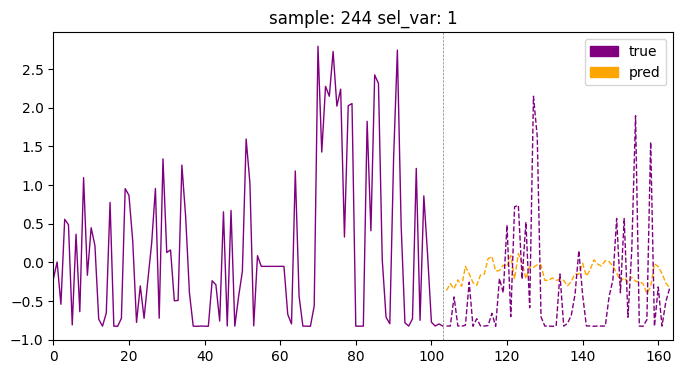

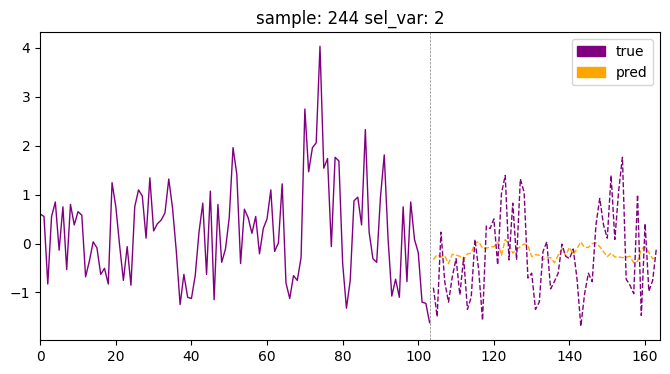

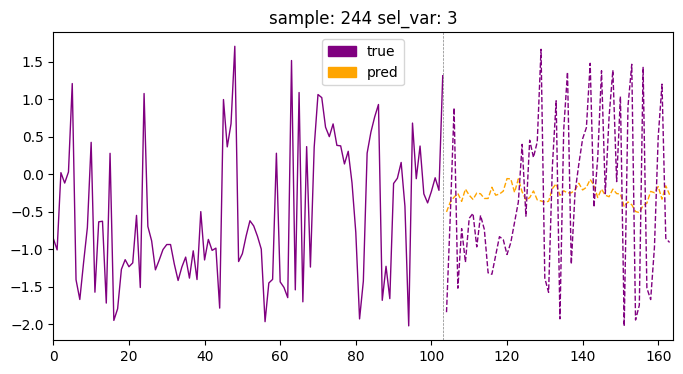

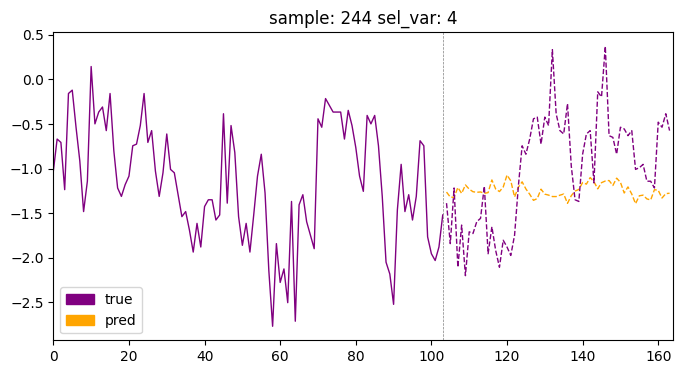

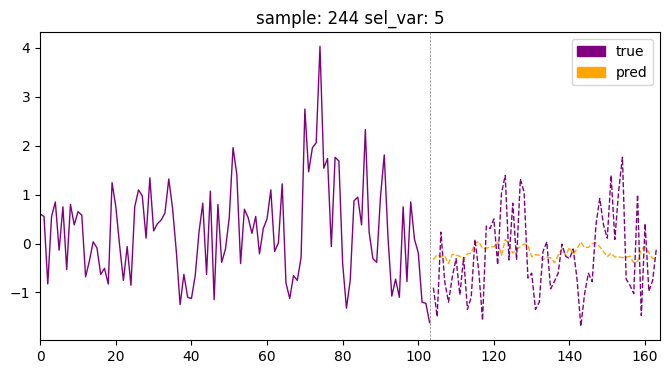

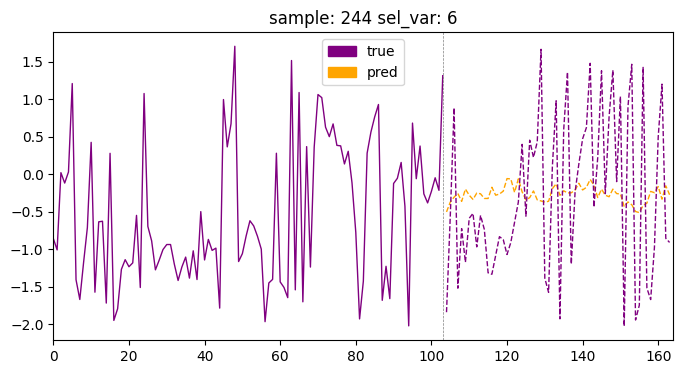

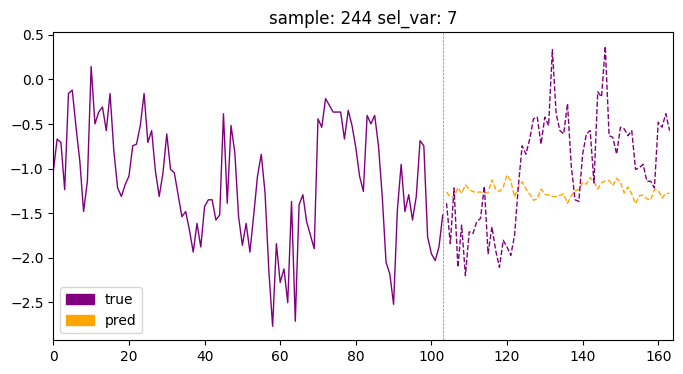

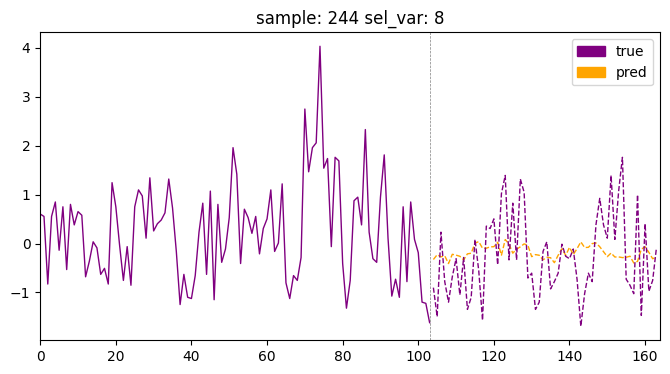

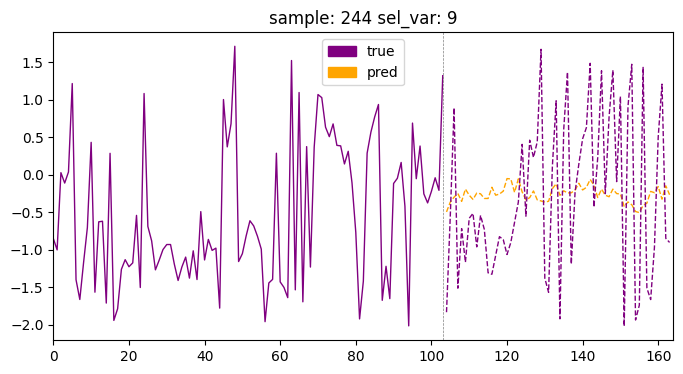

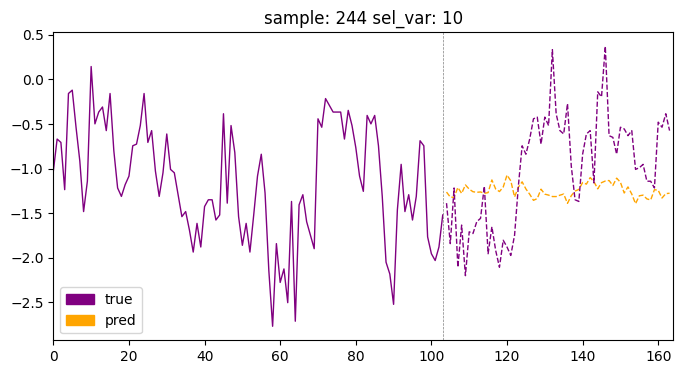

In [16]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

# Inference

In [156]:
new_df = pd.read_csv('cex4WindDataInterpolated.csv')
new_df['t'] = pd.to_datetime(new_df['t'])

fcst_date = "2003-01-01"

dates = pd.date_range(start=None, end=fcst_date, periods=fcst_history, freq=freq)
dates

DatetimeIndex(['2002-09-20', '2002-09-21', '2002-09-22', '2002-09-23',
               '2002-09-24', '2002-09-25', '2002-09-26', '2002-09-27',
               '2002-09-28', '2002-09-29',
               ...
               '2002-12-23', '2002-12-24', '2002-12-25', '2002-12-26',
               '2002-12-27', '2002-12-28', '2002-12-29', '2002-12-30',
               '2002-12-31', '2003-01-01'],
              dtype='datetime64[ns]', length=104, freq='24H')

In [157]:
new_df = new_df[new_df[datetime_col].isin(dates)].reset_index(drop=True)
new_df

,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,2002-09-20,262.0,1.075,9.0,283.4,286.000000,9.0,283.4,286.000,9.0,283.4,286.000000
1,2002-09-21,263.0,NaN,3.8,82.5,285.200000,3.8,82.5,285.200,3.8,82.5,285.200000
2,2002-09-22,264.0,NaN,4.3,96.6,283.300000,4.3,96.6,283.300,4.3,96.6,283.300000
3,2002-09-23,265.0,1.933,8.8,51.9,283.142857,8.8,51.2,283.475,8.6,50.9,283.533333
4,2002-09-24,266.0,4.770,7.5,270.8,284.600000,7.5,270.8,284.600,7.5,270.8,284.600000
...,...,...,...,...,...,...,...,...,...,...,...,...
99,2002-12-28,361.0,7.365,11.7,121.4,275.400000,11.7,121.4,275.400,11.7,121.4,275.400000
100,2002-12-29,362.0,NaN,5.4,27.5,273.300000,5.4,27.5,273.300,5.4,27.5,273.300000
101,2002-12-30,363.0,NaN,10.8,57.0,269.700000,10.8,57.0,269.700,10.8,57.0,269.700000
102,2002-12-31,364.0,NaN,9.7,74.4,265.700000,9.7,74.4,265.700,9.7,74.4,265.700000


## Preprocess Dataframe

In [159]:
from tsai.inference import load_learner

learn = load_learner('models/patchTST.pt')
filtered_df = learn.transform(new_df)
filtered_df

Initial memory usage: 9.88 KB   
Final memory usage  : 5.41 KB    (-45.3%)


,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,2002-09-20,0.940348,-0.626848,0.256933,0.962407,1.071027,0.256976,0.962111,1.070988,0.257288,0.965442,1.070879
1,2002-09-21,0.949947,-0.626848,-1.026068,-1.280310,0.919713,-1.026170,-1.280316,0.919711,-1.025967,-1.274778,0.919606
2,2002-09-22,0.959545,-0.626848,-0.902702,-1.122907,0.560334,-0.902790,-1.122933,0.560418,-0.902577,-1.117550,0.560322
3,2002-09-23,0.969144,-0.468315,0.207587,-1.621908,0.530613,0.207624,-1.629683,0.593514,0.158576,-1.627148,0.604445
4,2002-09-24,0.978742,0.055878,-0.113164,0.821749,0.806225,-0.113162,0.821471,0.806251,-0.112882,0.824940,0.806148
...,...,...,...,...,...,...,...,...,...,...,...,...
99,2002-12-28,1.890608,0.535356,0.923106,-0.846056,-0.933907,0.923225,-0.846118,-0.933463,0.923593,-0.841007,-0.933519
100,2002-12-29,1.900207,0.535356,-0.631298,-1.894294,-1.331112,-0.631356,-1.894221,-1.330573,-0.631119,-1.888079,-1.330617
101,2002-12-30,1.909806,0.535356,0.701048,-1.564975,-2.012028,0.701142,-1.564944,-2.011325,0.701492,-1.559127,-2.011351
102,2002-12-31,1.919404,0.535356,0.429644,-1.370733,-2.768606,0.429707,-1.370727,-2.767721,0.430034,-1.365101,-2.767727


## Apply Sliding Window

In [160]:
x_feat = new_df.columns[1:]
new_X, _ = prepare_forecasting_data(filtered_df, fcst_history=104, fcst_horizon=0, x_vars=x_vars, y_vars=None)
new_X.shape

(1, 11, 104)

In [161]:
new_scaled_preds, *_ = learn.get_X_preds(new_X)

In [162]:
new_scaled_preds = to_np(new_scaled_preds).swapaxes(1,2).reshape(-1, len(y_vars))
dates = pd.date_range(start=fcst_date, periods=fcst_horizon + 1, freq='7D')[1:]
preds_df = pd.DataFrame(dates, columns=[datetime_col])
preds_df.loc[:, y_vars] = new_scaled_preds
preds_df = learn.inverse_transform(preds_df)
preds_df

,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,2003-01-08,311.263629,3.641628,8.047986,139.587802,271.042042,8.047986,139.583594,271.043306,8.048432,139.581755,271.043538
1,2003-01-15,312.986096,4.700207,8.852722,133.515634,271.592818,8.852721,133.504226,271.598551,8.851110,133.499308,271.599569
2,2003-01-22,317.135263,4.908682,8.901155,142.783660,271.469363,8.901154,142.776634,271.471900,8.900840,142.773606,271.472365
3,2003-01-29,315.000482,4.291695,8.514251,141.265805,271.777244,8.514251,141.257611,271.778580,8.514284,141.254059,271.778827
4,2003-02-05,313.362579,4.523757,8.580405,141.818178,271.780145,8.580405,141.804241,271.786124,8.578414,141.798234,271.787189
5,2003-02-12,312.463920,3.943925,8.509455,153.806134,272.371668,8.509455,153.800335,272.374221,8.509466,153.797818,272.374683
6,2003-02-19,313.214067,4.055260,8.396521,157.474924,272.285999,8.396521,157.469595,272.287042,8.397202,157.467275,272.287237
7,2003-02-26,320.986338,4.419403,8.722304,153.583049,272.755671,8.722304,153.573358,272.759445,8.721500,153.569177,272.760122
8,2003-03-05,318.646127,4.322044,8.895182,153.600066,272.633999,8.895182,153.592438,272.634654,8.894452,153.589141,272.634782
9,2003-03-12,324.826447,3.550835,8.469263,143.004644,271.974727,8.469263,142.994154,271.977745,8.468098,142.989635,271.978291
